In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import re
import time
import json
import pathlib

from PIL import Image
import pickle
import numpy as np

## Download and prepare the MS-COCO dataset

In [2]:
# Download caption annotation files
annotation_zip = tf.keras.utils.get_file(
    fname='captions.zip',
    origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
    extract=True)
annotation_zip = pathlib.Path(annotation_zip)
annotation_file = annotation_zip.parents[0]/'annotations/captions_train2014.json'
os.remove(annotation_zip)

252878848/252872794 [==============================] - 41s 0us/step


In [38]:
# Download image files
image_zip = tf.keras.utils.get_file(
    fname='train2014.zip',
    origin='http://images.cocodataset.org/zips/train2014.zip',
    extract=True
)
image_zip = pathlib.Path(image_zip)
os.remove(image_zip)
PATH = image_zip.parents[0]/'train2014'

13493116928/13510573713 [============================>.] - ETA: 0s

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [6]:
annotations.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [8]:
annotations['annotations'][0].keys()

dict_keys(['image_id', 'id', 'caption'])

In [14]:
# Store captions and image names in vectors
all_captions = []
all_image_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = str(PATH/('COCO_train2014_'+'{:012d}.jpg'.format(image_id)))
    
    all_image_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions, all_image_name_vector, random_state=1)

In [15]:
len(train_captions), len(img_name_vector)

(414113, 414113)

## Preprocess he images using InceptionV3

Use InceptionV3 to classify each image. Extract features from the last convolutional layer.

In [16]:
# First convert the images into INceptionV3's expected format:
#  - 299 x 299 size
#  - use InceptionV3 preprocess_input to normalize image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

The last convolutional layer of InceptionV3's output is of shape ] `8 x 8 x 2048`.

- Forward each image through the network and store the output vector in a dictionary (image_name: feature_vector)
- Pickle the dictionary and save it to disk

In [72]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_feature_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

## Caching the features extracted from InceptionV3

In [39]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feed through the InceptionV3 model, store the output feature array in .npy file
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

for img, img_path in image_dataset:
    batch_features = image_feature_extract_model(img) # of shape [BATCH_SIZE, 8, 8, 2048]
    batch_features = tf.reshape(
        batch_features,
        (batch_features.shape[0], -1, batch_features.shape[3])) # of shape [BATCH_SIZE, 64, 2048]
    
    for bf, p in zip(batch_features, img_path):
        path_of_feature = p.numpy().decode('utf-8')
        np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

In [20]:
# Fing the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  oov_token='<unk>')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [22]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [23]:
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [24]:
# Calculate the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [25]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(331290, 331290, 82823, 82823)

## Creaet a tf.data dataset for training

In [90]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) # already add "<pad>"
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is [64, 2048]
features_shape = 2048
attention_features_shape = 64

In [92]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [93]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(
    lambda img_name, cap: tf.numpy_function(
        map_func,
        inp=[img_name, cap],
        Tout=[tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Model

In [30]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, attention_units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = tf.keras.layers.Dense(attention_units)
        self.W2 = tf.keras.layers.Dense(attention_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, keys, values):
        """Call function for attention module.
        Args:
            query: Hidden state from Decoder, of shape [BATCH_SIZE, dec_hidden_size]
            keys: Embedding features from Encoder, of shape [BATCH_SIZE, 64, enc_fc_size],
              note that, the InceptionV3 extracted features are pass through to the Encoder(with single FC layer)
            values: Equals to keys
        """
        _FC_key = self.W1(keys) # of shape [BATCH_SIZE, 64, attention_size]
        _FC_query = self.W2(query) # of shape [BATCH_SIZE, attention_size]
        _FC_query = tf.expand_dims(_FC_query, 1) # of shape [BATCH_SIZE, 1, attention_size]
        score = tf.nn.tanh(_FC_key + _FC_query) # of shape [BATCH_SIZE, 64, attention_size]
        
        _V = self.V(score) # of shape [BATCH_SIZE, 64, 1]
        attention_weights = tf.nn.softmax(_V, axis=1) # of shape [BATCH_SIZE, 64, 1]
        
        context_vector = attention_weights * values # of shape [BATCH_SIZE, 64, enc_fc_size]
        context_vector = tf.reduce_sum(context_vector, axis=1) # of shape [BATCH_SIZE, enc_fc_size]
        
        return context_vector, attention_weights

In [31]:
class CNN_Encoder(tf.keras.Model):
    """This Encoder passes features extracted from InceptionV3 through a FC alyer."""
    def __init__(self, embedding_dim, **kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')
        
    def call(self, x):
        return self.fc(x)

In [32]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, **kwargs):
        super(RNN_Decoder, self).__init__(**kwargs)
        self.units = units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units=units,
                                       activation='tanh',
                                       recurrent_initializer='glorot_uniform',
                                       return_sequences=True,
                                       return_state=True)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, values, query):
        """Call function for RNN Decoder module.
        Args:
            x: Input word tokens as index, of shape [BATCH_SIZE, 1]
            values: Output of CNN Encoder, of shape [BATCH_SIZE, 64, enc_fc_size]
            query: Output of previous RNN Decoder hidden state, of shape [BATCH_SIZE, dec_hidden_size]
        """
        # Get attention
        #   context_vector of shape [BATCH_SIZE, enc_fc_size]
        #   attention_weights of shape [BATCH_SIZE, 64, 1]
        context_vector, attention_weights = self.attention(query=query, keys=values, values=values)

        # Embedding the word index
        #   embedded_x of shape [BATCH_SIZE, 1, dec_embedding_size]
        x = self.embed(x)

        # Concatenate context_vector and embedded_x
        #   concatenated_x of shape [BATCH_SIZE, 1, enc_fc_size+dec_embedding_size]
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        # Passing the concatenated vector to the GRU
        #   output of shape [BATCH_SIZE, 1, gru_units]
        #   dec_hidden_state of shape [BATCH_SIZE, gru_units], used as next `query`
        output, dec_hidden_state = self.gru(x)
        
        # Passing the gru output to the first Dense layer fc1
        #   fc1_x of shape [BATCH_SIZE, 1, fc1_units]
        x = self.fc1(output)
        
        # Passing the fc1 output to the output Dense layer fc2
        #   fc2_x of shape [BATCH_SIZE, 1, fc2_units(vocab_size)]
        x = self.fc2(x)
        
        # Reshape fc2 output
        #   reshaped_x of shape [BATCH_SIZE * 1, fc2_units(vocab_size)]
        x = tf.reshape(x, [-1, x.shape[2]])
        
        return x, dec_hidden_state, attention_weights
    
    def reset_state(self, batch_size):
        """Return zeros dec_hidden_state"""
        return tf.zeros((batch_size, self.units))

In [40]:
encoder = CNN_Encoder(1024) # encode [None, 64, 2048] to [None, 64, 1024]
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [59]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    """Returns masked average loss on batch"""
    loss_ = loss_object(real, pred)
    # mask out the padding
    mask = tf.cast(tf.not_equal(real, 0), loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Checkpoint

In [60]:
checkpoint_dir = './checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

## Training

In [61]:
loss_plot = []

In [62]:
@tf.function
def train_step(img_tensor, caption):
    # loss is for each example sequence
    loss = 0
    
    # Initialize the decoder hidden state for each batch
    # baechase the captions are not related from image to image.
    # Used as the first `query` to attention.
    dec_hidden_state = decoder.reset_state(batch_size=caption.shape[0])

    dec_input = caption[:, :1]
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, caption.shape[1]):
            predictions, dec_hidden_state, _attention_weights = decoder(dec_input, features, dec_hidden_state)
            loss += loss_function(caption[:, i], predictions)
            # use teacher forcing
            dec_input = tf.expand_dims(caption[:, i], 1)
    
    # total_loss is for each sample and each sequence position(each word)
    total_loss = (loss / int(caption.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch_id, (img_tensor, caption)) in enumerate(dataset):
        batch_loss, token_loss = train_step(img_tensor, caption)
        total_loss += token_loss
        
        if batch_id % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch_id, batch_loss.numpy() / int(caption.shape[1]))) # print single batch token loss
            
    # Storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps)) # print batch-mean token loss
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

## Captioning

In [85]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))
    
    dec_hidden_state = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_feature_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[-1]))
    
    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, dec_hidden_state, attention_weights = decoder(dec_input, features, dec_hidden_state)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        
        # Use `tf.random.categorical` to randomly draw a prediction_index, 
        #   predictions is better a log-probability.
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot
        else:
            dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [86]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for word_idx in range(len_result):
        temp_att = np.resize(attention_plot[word_idx], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, word_idx + 1)
        ax.set_title(result[word_idx])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        
    plt.tight_layout()
    plt.show()

Real Caption: <start> two men with a kite at the beach <end>
Prediction Caption: two boys walk with a kite <end>


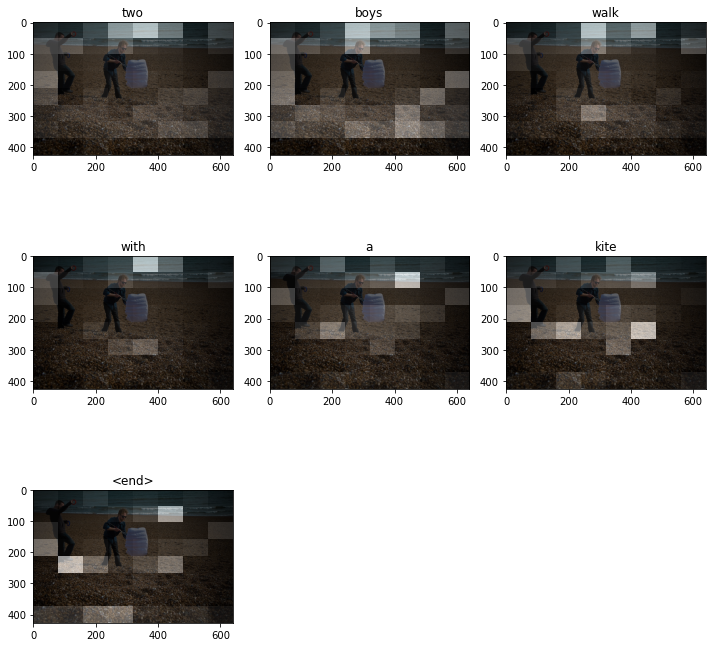

In [106]:
# captions on the validation set
random_id = np.random.randint(0, len(img_name_val))
image = img_name_val[random_id]
real_caption = ' '.join([tokenizer.index_word[i] 
                         for i in cap_val[random_id]
                         if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)